In [1]:
import gym
import numpy as np
import pickle
from model import Tabular, SoftmaxPolicy, EgreedyPolicy, \
    SigmoidTermination, IntraOptionQLearning, IntraOptionActionQLearning, \
    TerminationGradient, IntraOptionGradient
import random

discount = 0.99
lr_term = 0.25
lr_intra = 0.25
lr_critic = 0.5
epsilon = 0.01
temperature = 0.10
noptions = 4
nsteps = 1000

nruns = 1
nepisodes = 1500
verbose = True

rng = np.random.RandomState(1234)
env = gym.make('Fourrooms-v0')

history = np.zeros((nruns, nepisodes, 2))

for run in range(nruns):
    features = Tabular(env.observation_space.n)
    nfeatures, nactions = len(features), env.action_space.n

    # The intra-option policies are linear-softmax functions
    option_policies = [SoftmaxPolicy(rng, nfeatures, nactions, temperature)
                       for _ in range(noptions)]
    
    # The termination function are linear-sigmoid functions
    option_terminations = [SigmoidTermination(rng, nfeatures) 
                           for _ in range(noptions)]

    # E-greedy policy over options
    #policy_over_options = EgreedyPolicy(rng, nfeatures, noptions, epsilon)
    policy_over_options = SoftmaxPolicy(rng, nfeatures, noptions, 0.01)

    # Different choices are possible for the critic. Here we learn an
    # option-value function and use the estimator for the values upon arrival
    critic = IntraOptionQLearning(discount, lr_critic, 
                                  option_terminations, policy_over_options.weights)

    # Learn Qomega separately
    action_weights = np.zeros((nfeatures, noptions, nactions))
    action_critic = IntraOptionActionQLearning(discount, lr_critic, 
                                               option_terminations, 
                                               action_weights, critic)

    # Improvement of the termination functions based on gradients
    termination_improvement = TerminationGradient(option_terminations, 
                                                  critic, lr_term)

    # Intra-option gradient improvement with critic estimator
    intraoption_improvement = IntraOptionGradient(option_policies, 
                                                  lr_intra)

    for episode in xrange(nepisodes):       
        if episode == 750:
            # Save current option policies and termination functions
            pickle.dump(option_policies, open("save/policies_before.p", "wb"))
            pickle.dump(option_terminations, open("save/terminations_before.p", "wb"))    
            pickle.dump(policy_over_options, open("save/mainpolicy_before.p", "wb"))
            # Add patch of negative rewards
            env.negative_reward_states = [69, 70, 71, 79, 80, 81]
            
        phi = features(env.reset())
        option = policy_over_options.sample(phi)
        action = option_policies[option].sample(phi)
        critic.start(phi, option)
        action_critic.start(phi, option, action)

        cumreward = 0.
        duration = 1
        option_switches = 0
        avgduration = 0.
        
        for step in range(nsteps):
            observation, reward, done, _ = env.step(action)
            phi = features(observation)

            # Termination might occur upon entering the new state
            if option_terminations[option].sample(phi):
                option = policy_over_options.sample(phi)
                option_switches += 1
                avgduration += (1. / option_switches) * \
                    (duration - avgduration)
                duration = 1

            action = option_policies[option].sample(phi)

            # Critic update
            update_target = critic.update(phi, option, reward, done)
            action_critic.update(phi, option, action, reward, done)

            if isinstance(option_policies[option], SoftmaxPolicy):
                # Intra-option policy update
                critic_feedback = action_critic.value(phi, option, action)
                critic_feedback -= critic.value(phi, option)
                intraoption_improvement.update(phi, option, action, 
                                               critic_feedback)
                # Termination update
                termination_improvement.update(phi, option)

            cumreward += reward
            duration += 1
            if done:
                break

        history[run, episode, 0] = step
        history[run, episode, 1] = avgduration
        if verbose:
            print('Run {} episode {} steps {} cumreward {} avg. duration \
                {} switches {}'.format(run, episode, step, cumreward, 
                                       avgduration, option_switches))
            
    pickle.dump(option_policies, open("save/policies_after.p", "wb"))
    pickle.dump(option_terminations, open("save/terminations_after.p", "wb"))    
    pickle.dump(policy_over_options, open("save/mainpolicy_after.p", "wb"))

[2017-11-15 16:20:16,219] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace any calls to `register(timestep_limit=200)` with `register(tags={'wrapper_config.TimeLimit.max_episode_steps': 200)}`, . This change was made 12/28/2016 and is included in gym version 0.7.0. If you are getting many of these warnings, you may need to update universe past version 0.21.1
[2017-11-15 16:20:16,506] Making new env: Fourrooms-v0


Run 0 episode 0 steps 101 cumreward 1.0 avg. duration                 3.12765957447 switches 47
Run 0 episode 1 steps 145 cumreward 1.0 avg. duration                 2.89473684211 switches 76
Run 0 episode 2 steps 887 cumreward 1.0 avg. duration                 3.04861111111 switches 432
Run 0 episode 3 steps 663 cumreward 1.0 avg. duration                 2.88888888889 switches 351
Run 0 episode 4 steps 202 cumreward 1.0 avg. duration                 2.85321100917 switches 109
Run 0 episode 5 steps 15 cumreward 1.0 avg. duration                 2.66666666667 switches 9
Run 0 episode 6 steps 765 cumreward 1.0 avg. duration                 2.98181818182 switches 385
Run 0 episode 7 steps 150 cumreward 1.0 avg. duration                 3.30769230769 switches 65
Run 0 episode 8 steps 371 cumreward 1.0 avg. duration                 3.0 switches 185
Run 0 episode 9 steps 265 cumreward 1.0 avg. duration                 3.03846153846 switches 130
Run 0 episode 10 steps 333 cumreward 1.0 avg. 

Run 0 episode 96 steps 160 cumreward 1.0 avg. duration                 2.81818181818 switches 88
Run 0 episode 97 steps 10 cumreward 1.0 avg. duration                 6.0 switches 2
Run 0 episode 98 steps 7 cumreward 1.0 avg. duration                 2.5 switches 4
Run 0 episode 99 steps 7 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 100 steps 165 cumreward 1.0 avg. duration                 2.875 switches 88
Run 0 episode 101 steps 64 cumreward 1.0 avg. duration                 3.13333333333 switches 30
Run 0 episode 102 steps 81 cumreward 1.0 avg. duration                 2.68085106383 switches 47
Run 0 episode 103 steps 28 cumreward 1.0 avg. duration                 2.92857142857 switches 14
Run 0 episode 104 steps 3 cumreward 1.0 avg. duration                 3.0 switches 1
Run 0 episode 105 steps 25 cumreward 1.0 avg. duration                 3.4 switches 10
Run 0 episode 106 steps 49 cumreward 1.0 avg. duration                 3.33333333333 switches 21


Run 0 episode 195 steps 89 cumreward 1.0 avg. duration                 2.9347826087 switches 46
Run 0 episode 196 steps 22 cumreward 1.0 avg. duration                 3.0 switches 8
Run 0 episode 197 steps 18 cumreward 1.0 avg. duration                 3.83333333333 switches 6
Run 0 episode 198 steps 5 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 199 steps 4 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 200 steps 30 cumreward 1.0 avg. duration                 2.57894736842 switches 19
Run 0 episode 201 steps 23 cumreward 1.0 avg. duration                 2.91666666667 switches 12
Run 0 episode 202 steps 9 cumreward 1.0 avg. duration                 3.66666666667 switches 3
Run 0 episode 203 steps 26 cumreward 1.0 avg. duration                 2.46666666667 switches 15
Run 0 episode 204 steps 20 cumreward 1.0 avg. duration                 2.46153846154 switches 13
Run 0 episode 205 steps 27 cumreward 1.0 avg. duration     

Run 0 episode 311 steps 25 cumreward 1.0 avg. duration                 3.27272727273 switches 11
Run 0 episode 312 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 313 steps 54 cumreward 1.0 avg. duration                 2.92857142857 switches 28
Run 0 episode 314 steps 2 cumreward 1.0 avg. duration                 3.0 switches 1
Run 0 episode 315 steps 6 cumreward 1.0 avg. duration                 3.0 switches 3
Run 0 episode 316 steps 38 cumreward 1.0 avg. duration                 3.0 switches 18
Run 0 episode 317 steps 57 cumreward 1.0 avg. duration                 2.67647058824 switches 34
Run 0 episode 318 steps 11 cumreward 1.0 avg. duration                 3.2 switches 5
Run 0 episode 319 steps 15 cumreward 1.0 avg. duration                 2.625 switches 8
Run 0 episode 320 steps 8 cumreward 1.0 avg. duration                 3.0 switches 4
Run 0 episode 321 steps 5 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 322 steps

Run 0 episode 409 steps 16 cumreward 1.0 avg. duration                 3.0 switches 8
Run 0 episode 410 steps 17 cumreward 1.0 avg. duration                 3.14285714286 switches 7
Run 0 episode 411 steps 13 cumreward 1.0 avg. duration                 3.75 switches 4
Run 0 episode 412 steps 9 cumreward 1.0 avg. duration                 2.14285714286 switches 7
Run 0 episode 413 steps 39 cumreward 1.0 avg. duration                 2.69565217391 switches 23
Run 0 episode 414 steps 12 cumreward 1.0 avg. duration                 3.33333333333 switches 3
Run 0 episode 415 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 416 steps 15 cumreward 1.0 avg. duration                 2.25 switches 12
Run 0 episode 417 steps 14 cumreward 1.0 avg. duration                 2.55555555556 switches 9
Run 0 episode 418 steps 7 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 419 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 

Run 0 episode 522 steps 16 cumreward 1.0 avg. duration                 3.5 switches 6
Run 0 episode 523 steps 3 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 524 steps 1 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 525 steps 24 cumreward 1.0 avg. duration                 3.0 switches 12
Run 0 episode 526 steps 20 cumreward 1.0 avg. duration                 2.54545454545 switches 11
Run 0 episode 527 steps 9 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 528 steps 9 cumreward 1.0 avg. duration                 3.25 switches 4
Run 0 episode 529 steps 1 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 530 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 531 steps 9 cumreward 1.0 avg. duration                 3.0 switches 4
Run 0 episode 532 steps 15 cumreward 1.0 avg. duration                 2.2 switches 10
Run 0 episode 533 steps 15 cumreward 

Run 0 episode 615 steps 15 cumreward 1.0 avg. duration                 3.5 switches 6
Run 0 episode 616 steps 12 cumreward 1.0 avg. duration                 2.11111111111 switches 9
Run 0 episode 617 steps 17 cumreward 1.0 avg. duration                 2.88888888889 switches 9
Run 0 episode 618 steps 5 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 619 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 620 steps 15 cumreward 1.0 avg. duration                 3.5 switches 6
Run 0 episode 621 steps 13 cumreward 1.0 avg. duration                 2.71428571429 switches 7
Run 0 episode 622 steps 19 cumreward 1.0 avg. duration                 2.5 switches 12
Run 0 episode 623 steps 0 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 624 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 625 steps 18 cumreward 1.0 avg. duration                 2.8 switches 10
Run 0 episode 626 steps 5

Run 0 episode 738 steps 11 cumreward 1.0 avg. duration                 2.8 switches 5
Run 0 episode 739 steps 7 cumreward 1.0 avg. duration                 2.5 switches 4
Run 0 episode 740 steps 1 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 741 steps 18 cumreward 1.0 avg. duration                 2.28571428571 switches 14
Run 0 episode 742 steps 4 cumreward 1.0 avg. duration                 3.0 switches 2
Run 0 episode 743 steps 16 cumreward 1.0 avg. duration                 3.28571428571 switches 7
Run 0 episode 744 steps 10 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 745 steps 9 cumreward 1.0 avg. duration                 3.66666666667 switches 3
Run 0 episode 746 steps 4 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 747 steps 4 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 748 steps 6 cumreward 1.0 avg. duration                 2.66666666667 switches 3
Run 0 epis

Run 0 episode 828 steps 999 cumreward 0.0 avg. duration                 2.77127659574 switches 564
Run 0 episode 829 steps 8 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 830 steps 15 cumreward 1.0 avg. duration                 4.0 switches 5
Run 0 episode 831 steps 12 cumreward 1.0 avg. duration                 2.5 switches 8
Run 0 episode 832 steps 999 cumreward 0.0 avg. duration                 2.85981308411 switches 535
Run 0 episode 833 steps 999 cumreward 0.0 avg. duration                 2.68930390492 switches 589
Run 0 episode 834 steps 999 cumreward 0.0 avg. duration                 2.79174147217 switches 557
Run 0 episode 835 steps 22 cumreward 0.0 avg. duration                 3.5 switches 8
Run 0 episode 836 steps 999 cumreward 0.0 avg. duration                 2.84473197782 switches 541
Run 0 episode 837 steps 4 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 838 steps 302 cumreward 1.0 avg. duration            

Run 0 episode 932 steps 26 cumreward 1.0 avg. duration                 2.625 switches 16
Run 0 episode 933 steps 6 cumreward 1.0 avg. duration                 3.0 switches 1
Run 0 episode 934 steps 28 cumreward 1.0 avg. duration                 2.64705882353 switches 17
Run 0 episode 935 steps 11 cumreward 1.0 avg. duration                 2.25 switches 8
Run 0 episode 936 steps 4 cumreward 0.0 avg. duration                 1.8 switches 5
Run 0 episode 937 steps 55 cumreward 0.0 avg. duration                 2.86206896552 switches 29
Run 0 episode 938 steps 11 cumreward 1.0 avg. duration                 3.2 switches 5
Run 0 episode 939 steps 25 cumreward -2.0 avg. duration                 2.375 switches 16
Run 0 episode 940 steps 15 cumreward 1.0 avg. duration                 2.55555555556 switches 9
Run 0 episode 941 steps 6 cumreward -2.0 avg. duration                 2.25 switches 4
Run 0 episode 942 steps 32 cumreward 1.0 avg. duration                 2.88235294118 switches 17
Run 

Run 0 episode 1037 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 1038 steps 41 cumreward 0.0 avg. duration                 2.57692307692 switches 26
Run 0 episode 1039 steps 16 cumreward 1.0 avg. duration                 3.0 switches 8
Run 0 episode 1040 steps 23 cumreward 1.0 avg. duration                 2.375 switches 16
Run 0 episode 1041 steps 34 cumreward 1.0 avg. duration                 2.63157894737 switches 19
Run 0 episode 1042 steps 6 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 1043 steps 8 cumreward 1.0 avg. duration                 2.5 switches 4
Run 0 episode 1044 steps 10 cumreward -4.0 avg. duration                 2.4 switches 5
Run 0 episode 1045 steps 17 cumreward 0.0 avg. duration                 2.88888888889 switches 9
Run 0 episode 1046 steps 34 cumreward -2.0 avg. duration                 2.65 switches 20
Run 0 episode 1047 steps 6 cumreward 1.0 avg. duration                 2.66666666667 switches 

Run 0 episode 1138 steps 36 cumreward 0.0 avg. duration                 2.5652173913 switches 23
Run 0 episode 1139 steps 6 cumreward -2.0 avg. duration                 1.85714285714 switches 7
Run 0 episode 1140 steps 11 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 1141 steps 15 cumreward -2.0 avg. duration                 2.33333333333 switches 9
Run 0 episode 1142 steps 29 cumreward 1.0 avg. duration                 2.58823529412 switches 17
Run 0 episode 1143 steps 5 cumreward 0.0 avg. duration                 2.25 switches 4
Run 0 episode 1144 steps 34 cumreward 1.0 avg. duration                 2.94117647059 switches 17
Run 0 episode 1145 steps 39 cumreward 1.0 avg. duration                 2.52 switches 25
Run 0 episode 1146 steps 39 cumreward 0.0 avg. duration                 2.58333333333 switches 24
Run 0 episode 1147 steps 7 cumreward -1.0 avg. duration                 2.75 switches 4
Run 0 episode 1148 steps 28 cumreward 1.0 avg. durati

Run 0 episode 1235 steps 34 cumreward 1.0 avg. duration                 2.73684210526 switches 19
Run 0 episode 1236 steps 40 cumreward 1.0 avg. duration                 2.69565217391 switches 23
Run 0 episode 1237 steps 26 cumreward 1.0 avg. duration                 3.0 switches 12
Run 0 episode 1238 steps 58 cumreward 1.0 avg. duration                 2.54054054054 switches 37
Run 0 episode 1239 steps 10 cumreward 1.0 avg. duration                 2.66666666667 switches 6
Run 0 episode 1240 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 1241 steps 10 cumreward 1.0 avg. duration                 2.25 switches 8
Run 0 episode 1242 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 1243 steps 2 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 1244 steps 4 cumreward 0.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 1245 steps 37 cumreward 1.0 avg. duration                 2.85 sw

Run 0 episode 1330 steps 89 cumreward 1.0 avg. duration                 3.12195121951 switches 41
Run 0 episode 1331 steps 77 cumreward 1.0 avg. duration                 2.60416666667 switches 48
Run 0 episode 1332 steps 3 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 1333 steps 73 cumreward 1.0 avg. duration                 2.75 switches 40
Run 0 episode 1334 steps 10 cumreward 0.0 avg. duration                 2.5 switches 6
Run 0 episode 1335 steps 5 cumreward 1.0 avg. duration                 3.5 switches 2
Run 0 episode 1336 steps 17 cumreward -1.0 avg. duration                 2.88888888889 switches 9
Run 0 episode 1337 steps 33 cumreward 1.0 avg. duration                 2.57142857143 switches 21
Run 0 episode 1338 steps 81 cumreward 0.0 avg. duration                 2.70212765957 switches 47
Run 0 episode 1339 steps 66 cumreward 1.0 avg. duration                 2.71052631579 switches 38
Run 0 episode 1340 steps 115 cumreward 1.0 avg. duration        

Run 0 episode 1422 steps 42 cumreward 1.0 avg. duration                 2.46428571429 switches 28
Run 0 episode 1423 steps 25 cumreward 1.0 avg. duration                 2.71428571429 switches 14
Run 0 episode 1424 steps 0 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 1425 steps 45 cumreward 1.0 avg. duration                 2.28571428571 switches 35
Run 0 episode 1426 steps 9 cumreward 1.0 avg. duration                 2.14285714286 switches 7
Run 0 episode 1427 steps 40 cumreward 1.0 avg. duration                 2.6 switches 25
Run 0 episode 1428 steps 1 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 1429 steps 2 cumreward 1.0 avg. duration                 3.0 switches 1
Run 0 episode 1430 steps 40 cumreward 1.0 avg. duration                 2.95 switches 20
Run 0 episode 1431 steps 19 cumreward 1.0 avg. duration                 2.58333333333 switches 12
Run 0 episode 1432 steps 12 cumreward 1.0 avg. duration                 2.2 s

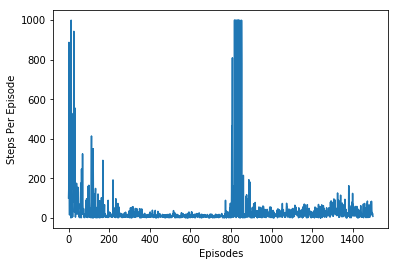

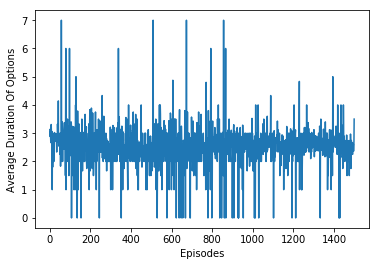

In [2]:
import matplotlib.pyplot as plt

experiment = "experiment13"
save = True

plt.plot(xrange(nepisodes), np.mean(history[:, :, 0], axis=0))
plt.xlabel("Episodes")
plt.ylabel("Steps Per Episode")
if save:
    plt.savefig("plots/{}/learning_curve_nsteps.png".format(experiment))
plt.show()

plt.plot(xrange(nepisodes), np.mean(history[:, :, 1], axis=0))
plt.xlabel("Episodes")
plt.ylabel("Average Duration Of Options")
if save:
    plt.savefig("plots/{}/learning_curve_duration.png".format(experiment))
plt.show()

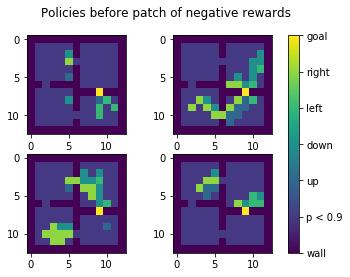

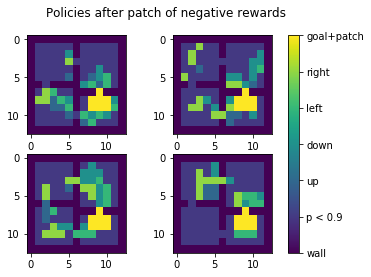

In [3]:
def visualize_policies(policies, title, filename, negative_patch=False, threshold=0.9):
    fig, axs = plt.subplots(2, 2)
    
    for i in xrange(2):
        for j in xrange(2):
            policy = policies[2 * i + j]
            rooms_map = -2 * env.occupancy
            n_states = policy.weights.shape[0]
            n_actions = 4
            for s in xrange(n_states):
                max_prob = np.max(policy.pmf([s]))
                if max_prob > threshold:
                    rooms_map[env.tocell[s]] = np.argmax(policy.pmf([s]))
                else:
                    rooms_map[env.tocell[s]] = -1
            rooms_map[env.tocell[env.goal]] = 4
            if negative_patch:
                for n in env.negative_reward_states:
                    rooms_map[env.tocell[n]] = 4
            im = axs[i, j].imshow(rooms_map)

    cbar = fig.colorbar(im, ax=axs.ravel().tolist())
    fig.suptitle(title)
    if negative_patch:
        labels = ['wall', 'p < {}'.format(threshold), 'up', 'down', 'left', 'right', 'goal+patch']
    else:
        labels = ['wall', 'p < {}'.format(threshold), 'up', 'down', 'left', 'right', 'goal']
    cbar.ax.set_yticklabels(labels)
    if save:
        plt.savefig("plots/{}/{}.png".format(experiment, filename))
    plt.show()

policies_before = pickle.load(open("save/policies_before.p", "rb"))
policies_after = pickle.load(open("save/policies_after.p", "rb"))

visualize_policies(policies_before, 
                   "Policies before patch of negative rewards", 
                   "policies_before")
visualize_policies(policies_after, 
                   "Policies after patch of negative rewards", 
                   "policies_after", 
                   negative_patch=True)

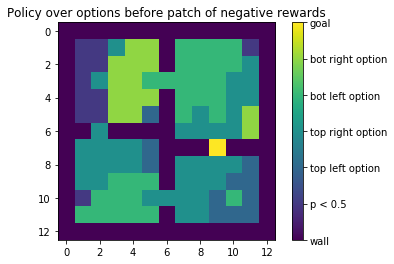

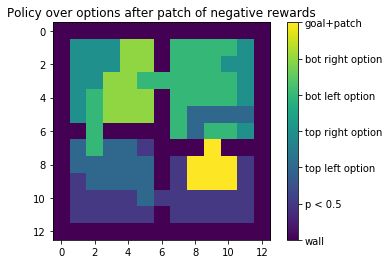

In [4]:
def visualize_policy(policy, goal, title, filename, negative_patch=False, threshold=0.5):
    rooms_map = -2 * env.occupancy
    n_states = policy.weights.shape[0]
    n_actions = 4
    for s in xrange(n_states):
        max_prob = np.max(policy.value([s]))
        if max_prob > threshold:
            rooms_map[env.tocell[s]] = np.argmax(policy.value([s]))
        else:
            rooms_map[env.tocell[s]] = -1
    rooms_map[env.tocell[goal]] = 4
    if negative_patch:
        for n in env.negative_reward_states:
            rooms_map[env.tocell[n]] = 4
    
    plt.imshow(rooms_map)
    plt.title(title)
    cbar = plt.colorbar()
    if negative_patch:
        labels = ['wall', 'p < {}'.format(threshold), 'top left option', 
                  'top right option', 'bot left option', 
                  'bot right option', 'goal+patch']
    else:
        labels = ['wall', 'p < {}'.format(threshold), 'top left option', 
                  'top right option', 'bot left option', 
                  'bot right option', 'goal']
    cbar.ax.set_yticklabels(labels)
    if save:
        plt.savefig("plots/{}/{}.png".format(experiment, filename))
    plt.show()
    
policy_over_options_before = pickle.load(open("save/mainpolicy_before.p", "rb"))
policy_over_options_after = pickle.load(open("save/mainpolicy_after.p", "rb"))
    
visualize_policy(policy_over_options_before, env.goal, 
                 "Policy over options before patch of negative rewards", 
                 "main_policy_before")
visualize_policy(policy_over_options_after, env.goal, 
                 "Policy over options after patch of negative rewards", 
                 "main_policy_after", 
                 negative_patch=True)

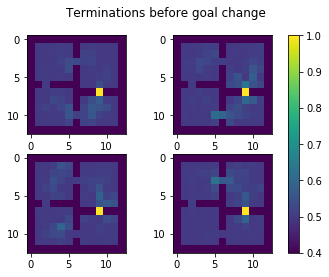

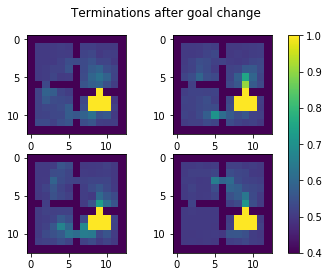

In [5]:
def visualize_terminations(terminations, goal, title, filename, negative_patch=False):
    fig, axs = plt.subplots(2, 2)
    
    for i in xrange(2):
        for j in xrange(2):
            termination = terminations[i + 2 * j]
            rooms_map = 0.4 * env.occupancy
            n_states = termination.weights.shape[0]
            for s in xrange(n_states):
                rooms_map[env.tocell[s]] = termination.pmf([s])
            rooms_map[env.tocell[goal]] = 1.0
            if negative_patch:
                for n in env.negative_reward_states:
                    rooms_map[env.tocell[n]] = 1.0
            im = axs[i, j].imshow(rooms_map)
            
            
    fig.suptitle(title)
    cbar = fig.colorbar(im, ax=axs.ravel().tolist())
    if save:
        plt.savefig("plots/{}/{}.png".format(experiment, filename))
    plt.show()
    
terminations_before = pickle.load(open("save/terminations_before.p", "rb"))
terminations_after = pickle.load(open("save/terminations_after.p", "rb"))

visualize_terminations(terminations_before, env.goal, 
                       "Terminations before goal change", 
                       "terminations_before")
visualize_terminations(terminations_after, env.goal, 
                       "Terminations after goal change", 
                       "terminations_after", 
                       negative_patch=True)